In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random
import os

In [2]:
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Step 1: Load and preprocess Cleveland dataset
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header=None)
df.columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df = df.astype(float)
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)

X = df.drop('target', axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define DNN using Functional API
#from tensorflow.keras.layers import Dropout

from tensorflow.keras.regularizers import l2

def build_dnn_functional(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(6, activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = Dense(26, activation='relu', kernel_regularizer=l2(0.01))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model, inputs, x



In [5]:
# Min-Max Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Build and train DNN
# Build and train DNN
dnn, dnn_input, dnn_hidden_output = build_dnn_functional(X_train.shape[1])
dnn.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
history = dnn.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_split=0.1,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],verbose=1)


Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.5117 - loss: 0.8776 - val_accuracy: 0.3333 - val_loss: 0.8861
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5115 - loss: 0.8709 - val_accuracy: 0.3333 - val_loss: 0.8823
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5473 - loss: 0.8639 - val_accuracy: 0.3333 - val_loss: 0.8780
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5650 - loss: 0.8566 - val_accuracy: 0.3333 - val_loss: 0.8731
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5767 - loss: 0.8492 - val_accuracy: 0.3333 - val_loss: 0.8678
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5803 - loss: 0.8418 - val_accuracy: 0.3810 - val_loss: 0.8623
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5736 - loss: 0.8347 - val_accuracy: 0.3810 - val_loss: 0.8566
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5736 - loss: 0.8277 - val_accuracy: 0.3810 - val_loss

In [7]:
# Extract features from second hidden layer
dnn_feature_extractor = Model(inputs=dnn_input, outputs=dnn_hidden_output)
train_features = dnn_feature_extractor.predict(X_train_scaled)
test_features = dnn_feature_extractor.predict(X_test_scaled)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [8]:
# Power Transform and PCA
power = PowerTransformer(method='yeo-johnson')
train_features_norm = power.fit_transform(train_features)
test_features_norm = power.transform(test_features)

In [9]:
pca = PCA(n_components=11)
train_pca = pca.fit_transform(train_features_norm)
test_pca = pca.transform(test_features_norm)

In [10]:
# Step 4: Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
lr.fit(train_pca, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [11]:
y_pred = lr.predict(test_pca)
y_prob = lr.predict_proba(test_pca)[:, 1]

In [12]:
# Step 5: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        49
           1       0.92      0.85      0.89        41

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90



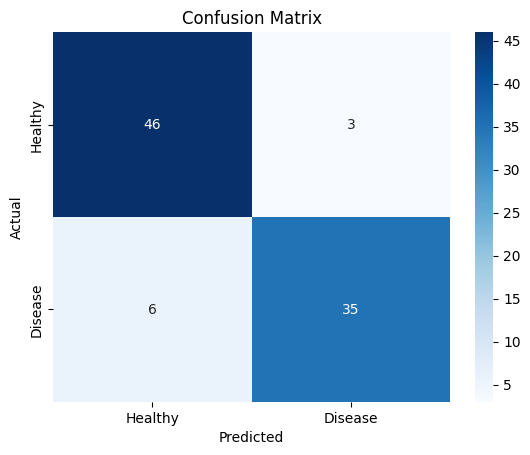

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import seaborn as sns # Import seaborn for heatmap
import matplotlib.pyplot as plt # Import matplotlib for plotting

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Healthy", "Disease"], yticklabels=["Healthy", "Disease"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

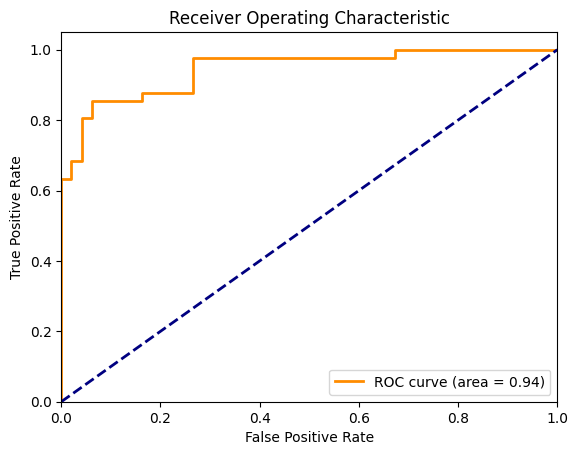

In [14]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

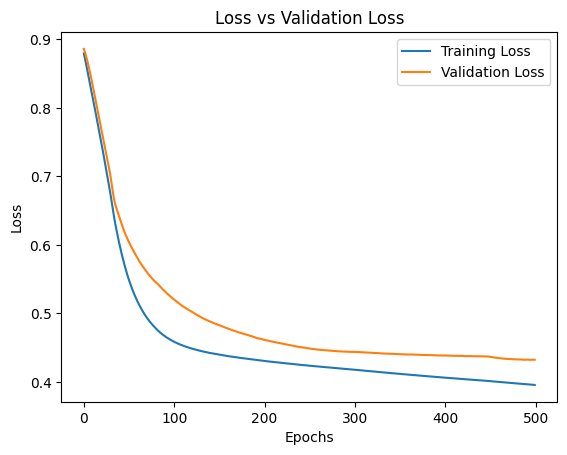

In [15]:
# Loss vs Validation Loss Plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()